(gallery-app-helmholtz)=

# Coils

In this example we show how to model air-coils, then combine two coils into a Helmholtz-pair and visualize the homogeneity of the resulting magnetic field. A nice explanation of coils and the magnetic field is given [here](https://www.nagwa.com/en/explainers/186157825721/#:~:text=The%20magnetic%20field%20strength%2C%20%F0%9D%90%B5,%EF%8A%AD%20T%E2%8B%85m%2FA.). With the code examples below you can easily compare Magpylib results to results presented in this tutorial.

## Coil models

**Model 1:** The coil consists of multiple windings, each of which can be modeled with a circular current loop which is realized by the `Circle` class. The individual windings are combined into a `Collection` which itself behaves like a single magnetic field source.

In [1]:
import numpy as np
import magpylib as magpy

coil1 = magpy.Collection()
for z in np.linspace(-8, 8, 16):
    winding = magpy.current.Circle(
        current=100,
        diameter=10,
        position=(0,0,z),
    )
    coil1.add(winding)

coil1.show()

**Model 2:** The coil is in reality more like a spiral, which can be modeled using the `Polyline` class. However, a good spiral approximation requires many small line segments, which makes the computation slower.

In [2]:
import numpy as np
import magpylib as magpy

ts = np.linspace(-8, 8, 300)
vertices = np.c_[5*np.cos(ts*2*np.pi), 5*np.sin(ts*2*np.pi), ts]
coil2 = magpy.current.Polyline(
    current=100,
    vertices=vertices
)

coil2.show()

**Model 3:** A [Helmholtz coil](https://en.wikipedia.org/wiki/Helmholtz_coil) is a device for producing a region of nearly uniform magnetic field. It consists of two coils on the same axis, carrying an equal electric current in the same direction. In classical layouts, the distance between the coils is similar to the coil radius.

In [3]:
# create a finite sized Helmholtz coil-pair
coil1 = magpy.Collection()
for z in np.linspace(-1, 1, 5):
    for r in np.linspace(4, 5, 5):
        winding = magpy.current.Circle(
            current=10,
            diameter=2*r,
            position=(0,0,z),
        )
        coil1.add(winding)

coil1.position = (0,0,5)
coil2 = coil1.copy(position=(0,0,-5))

helmholtz = magpy.Collection(coil1, coil2)

helmholtz.show()

## Plotting the field

Streamplot from Matplotlib is a powerful tool to outline the field lines. However, it must be understood that streamplot shows only a projection of the field onto the observation plane. All field components that point out of the plane become invisible. In out example we choose symmetry planes, where the perpendicular component is negligible.

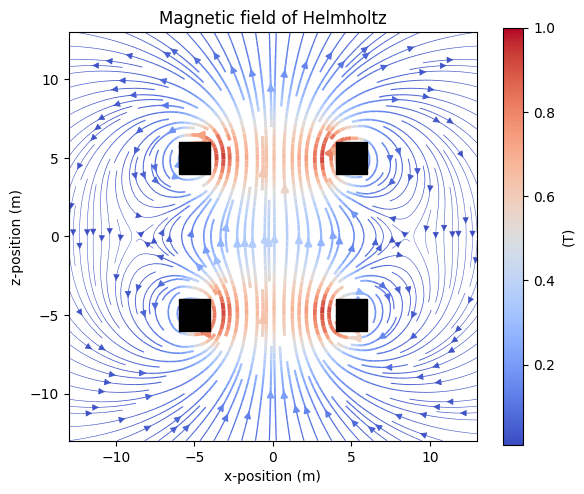

In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(6,5))

# create grid
ts = np.linspace(-13, 13, 20)
grid = np.array([[(x,0,z) for x in ts] for z in ts])

# compute and plot field of Helmholtz
B = magpy.getB(helmholtz, grid)
Bamp = np.linalg.norm(B, axis=2)
Bamp /= np.amax(Bamp)

sp = ax.streamplot(
    grid[:,:,0], grid[:,:,2], B[:,:,0], B[:,:,2],
    density=2,
    color=Bamp,
    linewidth=np.sqrt(Bamp)*3,
    cmap='coolwarm',
)

# plot coil outline
from matplotlib.patches import Rectangle
for loc in [(4,4), (4,-6), (-6,4), (-6,-6)]:
    ax.add_patch(Rectangle(loc, 2, 2, color='k', zorder=10))

# figure styling
ax.set(
    title='Magnetic field of Helmholtz',
    xlabel='x-position (m)',
    ylabel='z-position (m)',
    aspect=1,
)
plt.colorbar(sp.lines, ax=ax, label='(T)')

plt.tight_layout()
plt.show()

## Helmholtz field homogeneity

While the optimal solution is given by two current loops, real world applications must deal with finite sizes and limited construction space. Here Magpylib enables fast analysis of different possible geometries.

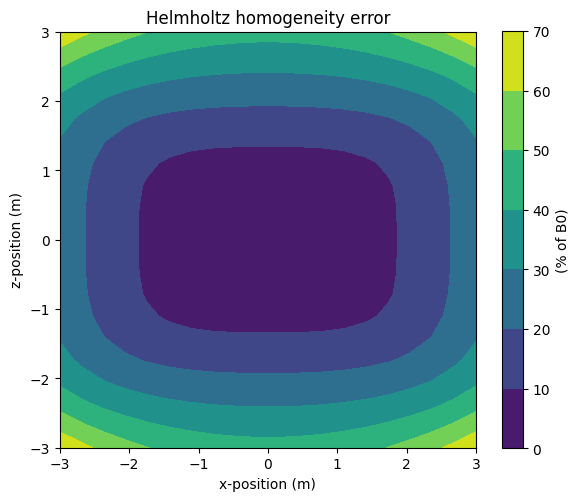

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6,5))

# compute field of the coil pair on grid
ts = np.linspace(-3, 3, 20)
grid = np.array([[(x,0,z) for x in ts] for z in ts])
B = helmholtz.getB(grid)

# field at center
B0 = helmholtz.getB((0,0,0))
B0amp = np.linalg.norm(B0)

# homogeneity error
err = np.linalg.norm((B-B0)/B0amp, axis=2)

# plot error on grid
sp = ax.contourf(grid[:,:,0], grid[:,:,2], err*100)

# figure styling
ax.set(
    title='Helmholtz homogeneity error',
    xlabel='x-position (m)',
    ylabel='z-position (m)',
    aspect=1,
)
plt.colorbar(sp, ax=ax, label='(% of B0)')

plt.tight_layout()
plt.show()

Notice that in such finite sized arrangements the field is not very homogeneous.